In [1]:
# %matplotlib nbagg
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit


## Data preset

In [2]:
inputFilePath = 'C:\\Researches\\Data\\CrBr3\\202110\\RIXS\\'
base = 'Cr'
energyDispersion = 0.005356 #eV/subpixel
energyResolution = 0.061577   #eV
dataLength = 2000   #subpixels

In [3]:
def gaussian_norm(x,mu,gamma,amp):
    sig = gamma/2/np.sqrt(2*np.log(2))
    norm = (1./(np.sqrt(2*np.pi)*sig))
    return amp*norm*np.exp(-((x-mu)**2)/(2*sig**2))

def PseudoVoigt(x,x0,dx_l,dx_g,a,eta):
    dx_g = dx_g/2.355
    dx_l = dx_l/2.
    return a*(eta*(np.sqrt(np.log(2.)/np.pi) * (1./dx_g) * np.exp(-np.log(2.) * (x-x0)**2 / dx_g**2)) + (1.-eta)/(np.pi*dx_l*(1. + (x-x0)**2 / dx_l**2)))

def zeroEnergy( xUncorrEnegy,uncorrData ):
    global energyResolution
    popt,_ = curve_fit(gaussian_norm, xUncorrEnegy, uncorrData, p0=[ 0 , energyResolution/2.355 , np.max(uncorrData)/10])
    # print(popt)
    xCorrEnergy = xUncorrEnegy-popt[0]
    return xCorrEnergy

def xCorr(refData, uncorrData):
    global dataLength

    corr = signal.correlate(refData, uncorrData)  # consider full pattern
    lags = signal.correlation_lags(len(refData), len(uncorrData))
    lag = lags[np.argmax(corr)]
    uncorrData = np.roll(uncorrData, lag)

    corr = signal.correlate(refData[(dataLength-50):(dataLength+50)], uncorrData[(dataLength-50):(dataLength+50)])  # just consider elastic peak
    lags = signal.correlation_lags(len(refData[(dataLength-50):(dataLength+50)]), len(uncorrData[(dataLength-50):(dataLength+50)]))
    lag = lags[np.argmax(corr)]
    corrData = np.roll(uncorrData, lag)
    return corrData

def elasticShift(pixelData):

    global energyDispersion
    global dataLength

    peaks, _ = signal.find_peaks(pixelData,height=20,width=3)   #height and width of the elastic peak
    xdataPixel = np.arange(len(pixelData))
    
    xdataPixel = xdataPixel[(peaks[-1]-dataLength):(peaks[-1]+100)]   #data length picked
    energyData = pixelData[(peaks[-1]-dataLength):(peaks[-1]+100)]    #need to be changed with the zero list
    
    xDataEnergy = (xdataPixel - peaks[-1]) * energyDispersion * -1

    return [xDataEnergy,energyData]

def getdata(scannumber):
    global inputFilePath
    global base
    
    if scannumber < 10:
        filename = base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = base+"_"+"0"+str(scannumber)
    else:    
        filename = base+"_"+str(scannumber)

    f1 = h5py.File(inputFilePath+filename+"_d1.h5", 'r')
    f2 = h5py.File(inputFilePath+filename+"_d2.h5", 'r')
    f3 = h5py.File(inputFilePath+filename+"_d3.h5", 'r')

    ccd1 = f1['entry']['analysis']['spectrum'][()]
    ccd2 = f2['entry']['analysis']['spectrum'][()]
    ccd3 = f3['entry']['analysis']['spectrum'][()]
    
    [_,data1] = elasticShift(ccd1)
    [xdata,data2] = elasticShift(ccd2)
    [_,data3] = elasticShift(ccd3)

    data1 = xCorr(data2,data1)    #xCorr(refData, uncorrData)
    data3 = xCorr(data2,data3)
    tempData = (data1+data2+data3)/3
    xdata = zeroEnergy(xdata,tempData)
    data = [xdata,tempData]
    
    return data

def combineData(scans):
    sumData = np.zeros(dataLength+100)    #only change with the picked-up data length
    for i,s in enumerate(scans):
        [xData,oneData] = getdata(s)
        if i == 0:
            [xRefData,refData] = [xData,oneData]
        else:
            oneData = xCorr(refData,oneData)    #xCorr(refData, uncorrData):
        sumData = sumData+oneData
    aveData = sumData/len(scans)

    return [xRefData,aveData]

## One scan plot

(-0.5, 0.5)

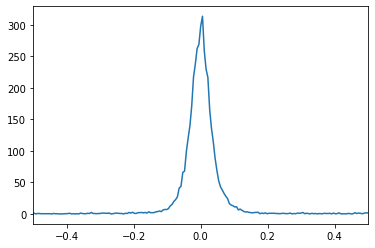

In [4]:
fig = plt.figure()
[X,Y]=getdata(21)   #scan number
plt.plot(X,Y)
plt.xlim([-0.5,0.5])

## Multi scans combined plot

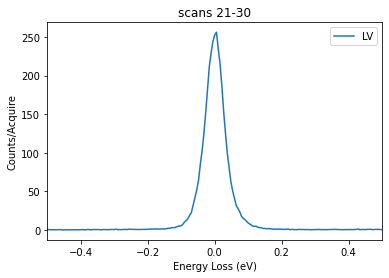

In [8]:
fig = plt.figure() 

#####################################

scans = np.arange(21,30+1)  #data range

[X,Y]=combineData(scans)

plt.plot(X,Y,  label='LV')

######################################

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Counts/Acquire')
plt.xlim([-0.5,0.5])
plt.title('scans '+str(scans[0])+'-'+str(scans[-1]))
plt.legend()

## Multi scans shifted plot

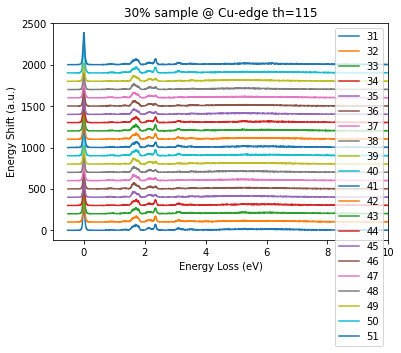

In [6]:
fig = plt.figure()

scans = np.arange(31,51+1)

sumData = np.zeros(dataLength)

for i,s in enumerate(scans):
    [xData,oneData] = getdata(s)
    plt.plot(xData,oneData+100*i,label=str(s))

plt.xlabel('Energy Loss (eV)')
plt.ylabel('Energy Shift (a.u.)')
plt.xlim([-1,10])
plt.title('30% sample @ Cu-edge th=115')
plt.legend(loc='upper right')

## Energy mapping plot

<ipython-input-7-405f39719ca0>:16: UserWarning: The input coordinates to pcolor are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolor.
  plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=60)


Text(0.5, 1.0, 'Energy map')

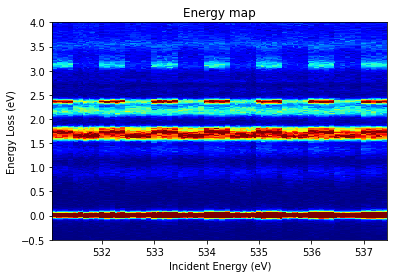

In [7]:
fig = plt.figure()

scans = np.arange(11,74+1)
Ei = np.arange(531.1,537.4+0.05,0.1)
eiNum = len(scans)

matrixData = np.zeros(((dataLength+100), eiNum))
matrixEloss = np.zeros(((dataLength+100), eiNum))
matrixEi,_ = np.meshgrid(Ei,np.arange(dataLength+100))

for i,s in enumerate(scans):
    [Eloss,oneData] = getdata(s)
    matrixData[:,i] = oneData.T
    matrixEloss[:,i] = Eloss.T

plt.pcolor(matrixEi,matrixEloss,matrixData,shading='auto',cmap='jet',vmax=60)
plt.ylim([-0.5,4])
plt.xlabel('Incident Energy (eV)')
plt.ylabel('Energy Loss (eV)')
plt.title('Energy map')